# SVM (Support Vector Machines)

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

In [1]:
import pandas as pd
import matplotlib.pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics.

In [2]:
!curl -o cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20675  100 20675    0     0  16553      0  0:00:01  0:00:01 --:--:-- 16553


In [3]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


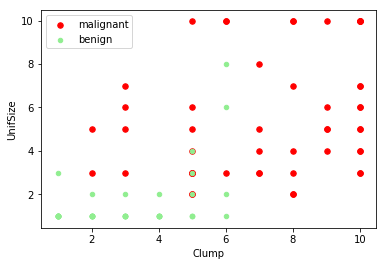

In [4]:
plot = cell_df[cell_df['Class'] == 4][0:50].plot(
    kind='scatter', x='Clump', y='UnifSize', color='Red', s=30, label='malignant')

cell_df[cell_df['Class'] == 2][0:50].plot(
    kind='scatter', x='Clump', y='UnifSize', color='LightGreen', label='benign', s=20,ax=plot);

# ```int``` Type Conversion

We can notice that benign cells usually have small clump and uniformity of cell size.

In [6]:
cell_df.dtypes
# let's find out what is wrong with BareNuc, it appears to have integers

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [7]:
bn = np.squeeze(cell_df[['BareNuc']].values) 
bn # all values are simply strings of integers and string '?'

array(['1', '10', '2', '4', '1', '10', '10', '1', '1', '1', '1', '1', '3',
       '3', '9', '1', '1', '1', '10', '1', '10', '7', '1', '?', '1', '7',
       '1', '1', '1', '1', '1', '1', '5', '1', '1', '1', '1', '1', '10',
       '7', '?', '3', '10', '1', '1', '1', '9', '1', '1', '8', '3', '4',
       '5', '8', '8', '5', '6', '1', '10', '2', '3', '2', '8', '2', '1',
       '2', '1', '10', '9', '1', '1', '2', '1', '10', '4', '2', '1', '1',
       '3', '1', '1', '1', '1', '2', '9', '4', '8', '10', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '6', '10', '5', '5', '1', '3',
       '1', '3', '10', '10', '1', '9', '2', '9', '10', '8', '3', '5', '2',
       '10', '3', '2', '1', '2', '10', '10', '7', '1', '10', '1', '10',
       '1', '1', '1', '10', '1', '1', '2', '1', '1', '1', '?', '1', '1',
       '5', '5', '1', '?', '8', '2', '1', '10', '1', '10', '5', '3', '1',
       '10', '1', '1', '?', '10', '10', '1', '1', '3', '?', '2', '10',
       '1', '1', '1', '1', '1', '1', '10', '10'

In [8]:
print(len(cell_df))
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
print(len(cell_df))

699
683


In [9]:
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int') # convert to integers
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

# Make a Pairplot

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


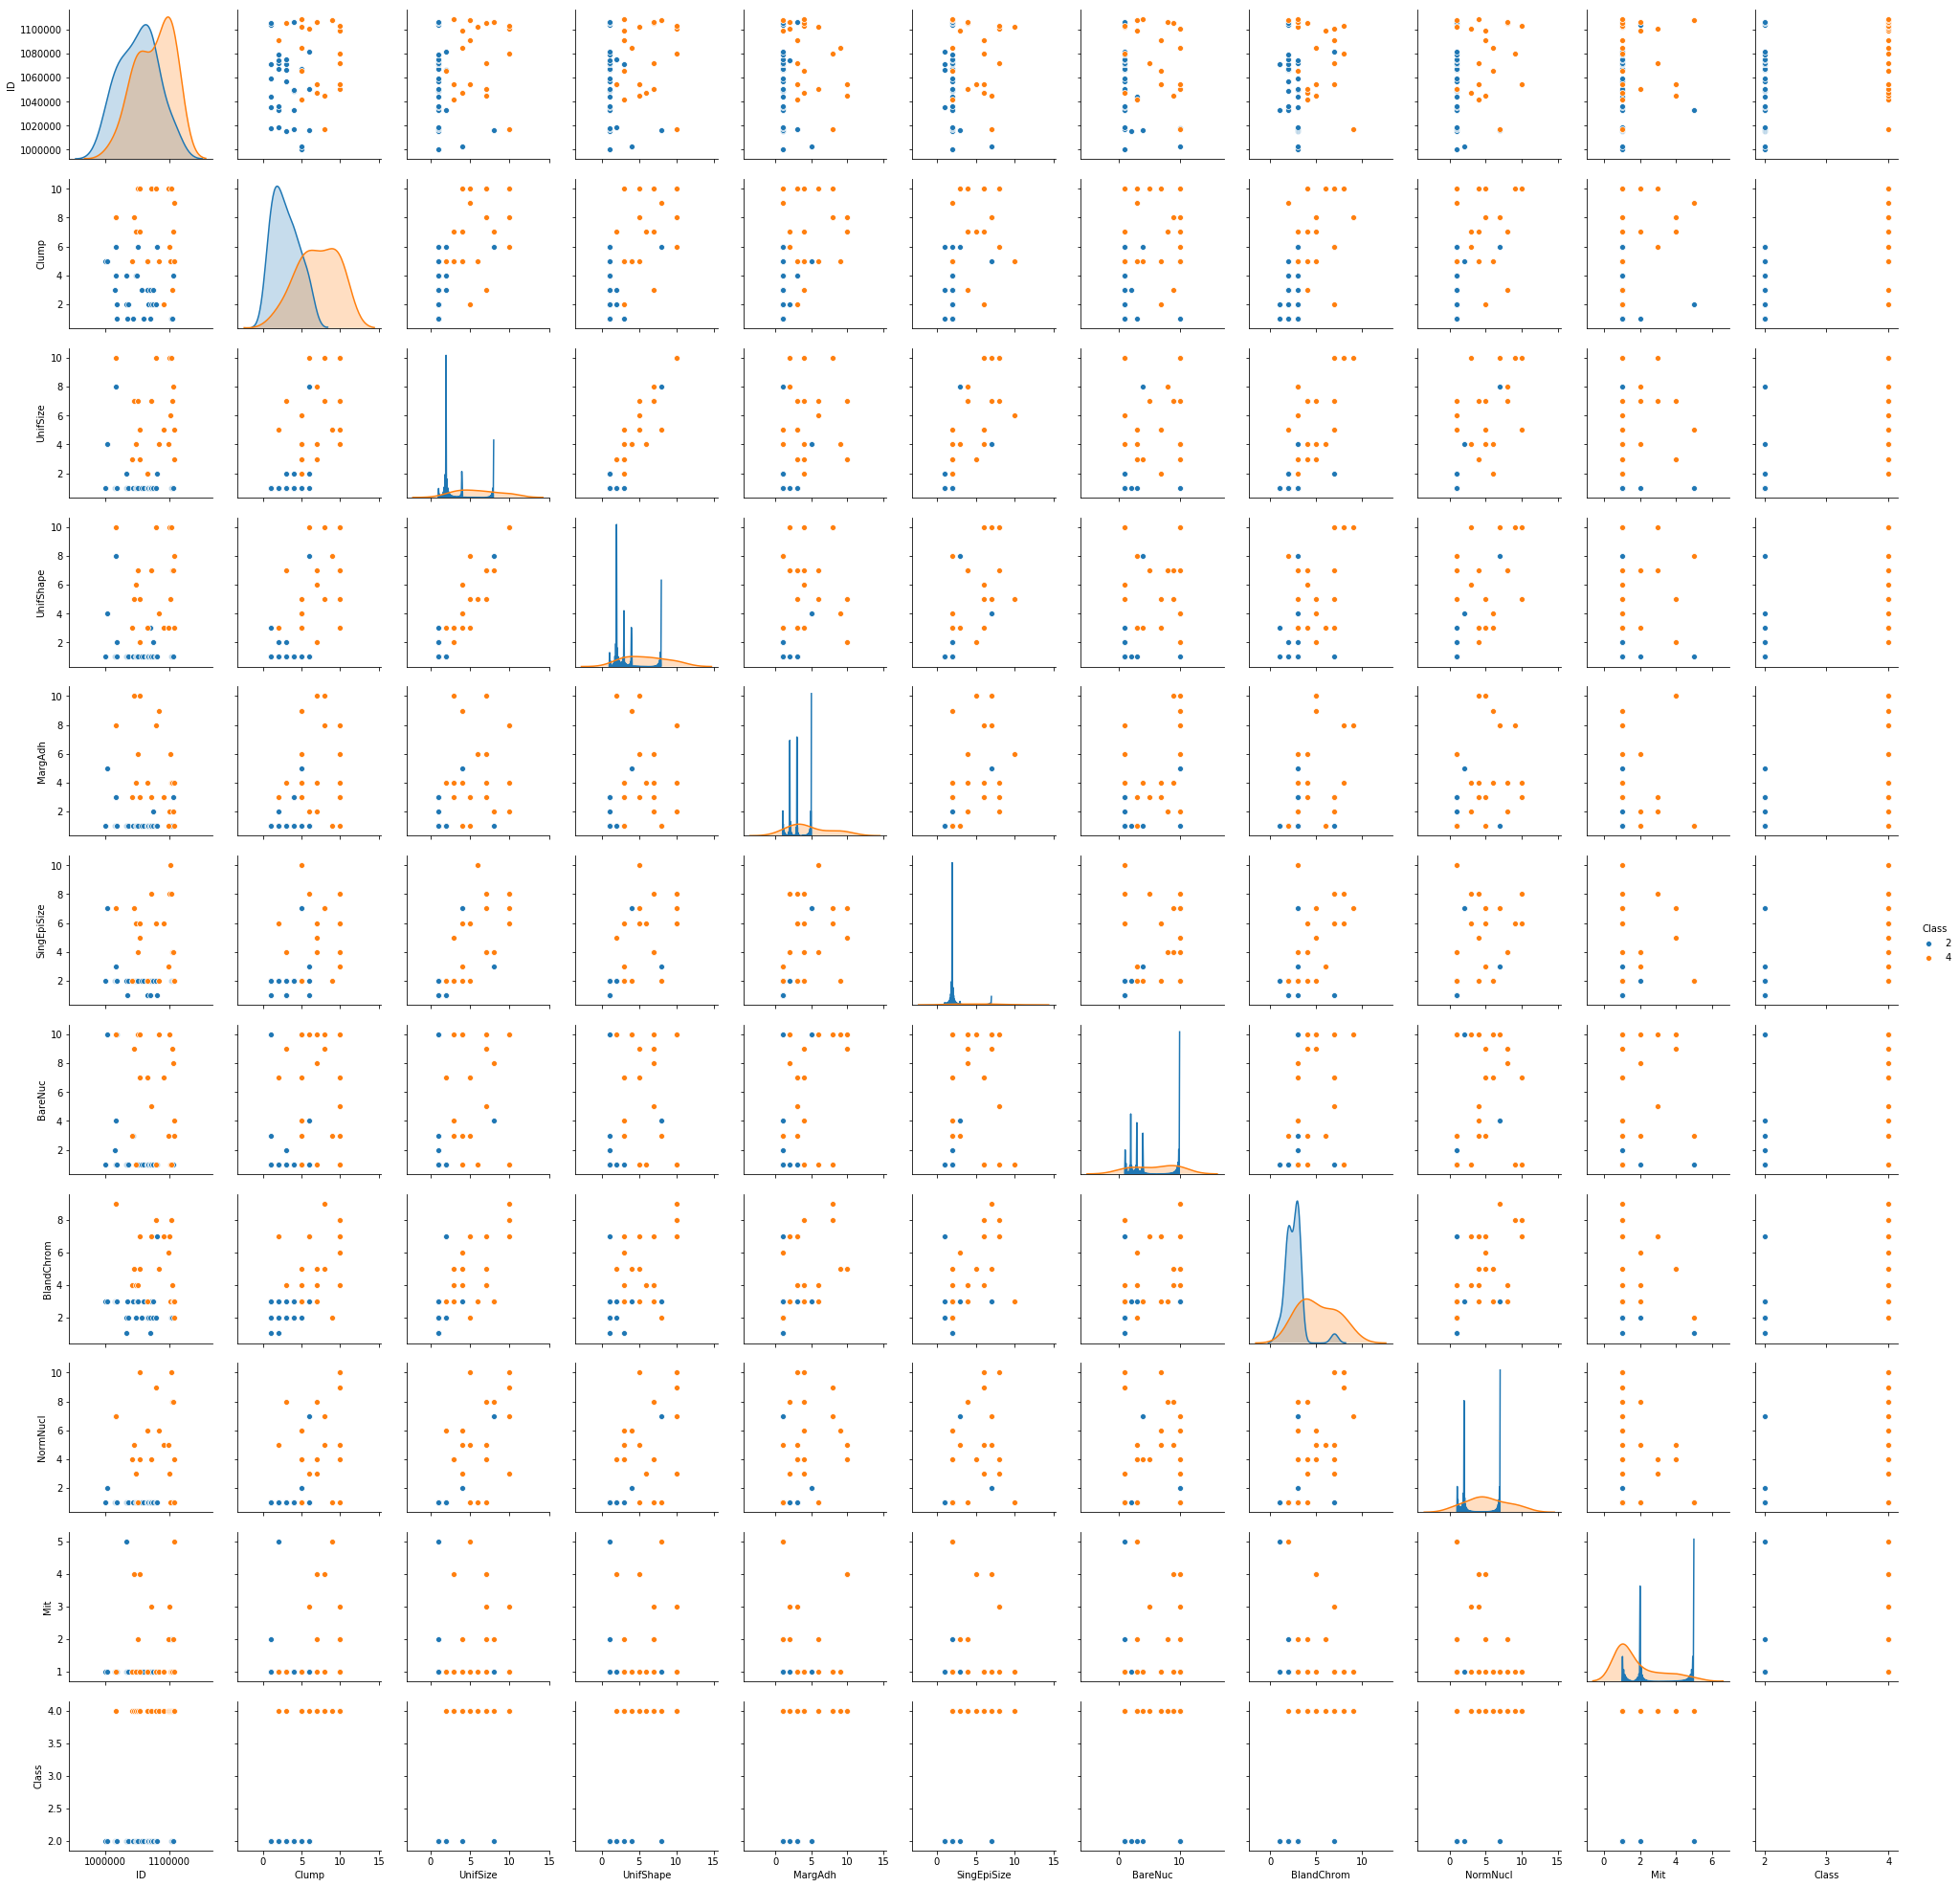

In [17]:
import seaborn as sns
sns.pairplot(cell_df[0:50], hue='Class')

# save a figure
plt.savefig("Cells Pairplot.svg", format="svg")

# Building A Model

In [18]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

In [11]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


# Modeling SVM

The SVM algorithm offers a choice of kernel functions for performing its processing. 

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [13]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
y_hat = clf.predict(X_test)
y_hat[0:5]

array([2, 4, 2, 4, 2])

# Evaluation

<table>
  <tr>
    <th></th>
    <th>Predicted<br><span style="font-weight:bold">No</span></th>
    <th>Predicted<br><span style="font-weight:bold">Yes</span></th>
  </tr>
  <tr>
    <td><span style="font-weight:bold">No</span></td>
    <td>True Negative</td>
    <td>False Positive</td>
  </tr>
  <tr>
    <td><span style="font-weight:bold">Yes</span></td>
    <td>False Negative</td>
    <td>True Positive</td>
  </tr>
</table>

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_hat, labels=[2,4]), '\nWe have 5 False Postives')

[[85  5]
 [ 0 47]] 
We have 5 False Postives


In [16]:
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

          2       1.00      0.94      0.97        90
          4       0.90      1.00      0.95        47

avg / total       0.97      0.96      0.96       137

